In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw4.ipynb")

---

<h1><center>SDSE Homework 4 <br><br> Text Classification with Naive Bayes </center></h1>

---

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

In this homework we will apply the technique of Naive Bayes classification to the problem of categorizing text-based documents. The dataset that we will work with is a selection of posts from scikit-learn's ['20 newsgroups' dataset](https://scikit-learn.org/stable/datasets/real_world.html#newsgroups-dataset). This dataset contains some 18000 newsgroup posts in 20 different categories, such as politics, autos, electronics, atheism, and hockey. For simplicity, we will focus on just two of the categories: computer graphics and motorcycles.

The next cell loads the data from a pickle file. The file contains training data `(Xtrain, ytrain)` and testing data `(Xtest,ytest)`. Each entry in `Xtrain` and `Xtest` is a particular post. The corresponding output in `ytrain` or `ytest` is its category.
`categories` is the set of all categories.
`vocabulary` is the feature set; i.e. words that will be recognized the model.

# 0. Load the data

In [3]:
with open('hw4_text.pickle','rb') as file:
    Xtrain, ytrain, Xtest, ytest, categories, vocabulary = pickle.load(file)

# 1. Define constants

Define the following variables in terms of quantities loaded from the pickle file. 
+ `N` ... number of documents in the training corpus
+ `K` ... number of document categories
+ `D` ... number of words in the vocabulary (features)

In [11]:
N = len(Xtrain)
K = len(categories)
D = len(vocabulary)

In [12]:
grader.check("q1")

q1 results: All test cases passed!

# 2. Find the number of training documents for each category

Create a dictionary called `docs_per_category` that stores the number of documents in the training data in each category.

In [18]:
ytrain

array(['rec.motorcycles', 'comp.graphics', 'comp.graphics',
       'rec.motorcycles', 'rec.motorcycles', 'rec.motorcycles',
       'comp.graphics', 'comp.graphics', 'rec.motorcycles',
       'rec.motorcycles', 'comp.graphics', 'rec.motorcycles',
       'rec.motorcycles', 'comp.graphics', 'comp.graphics',
       'rec.motorcycles', 'comp.graphics', 'comp.graphics',
       'comp.graphics', 'rec.motorcycles', 'comp.graphics',
       'rec.motorcycles', 'rec.motorcycles', 'comp.graphics',
       'comp.graphics', 'rec.motorcycles', 'rec.motorcycles',
       'rec.motorcycles', 'rec.motorcycles', 'rec.motorcycles',
       'rec.motorcycles', 'rec.motorcycles', 'rec.motorcycles',
       'comp.graphics', 'rec.motorcycles', 'comp.graphics',
       'comp.graphics', 'rec.motorcycles', 'rec.motorcycles',
       'comp.graphics', 'rec.motorcycles', 'comp.graphics',
       'rec.motorcycles', 'comp.graphics', 'comp.graphics',
       'rec.motorcycles', 'rec.motorcycles', 'rec.motorcycles',
       'comp.gra

In [26]:
docs_per_category = dict.fromkeys(categories,0)
for category in categories:
    docs_per_category[category] = np.count_nonzero(ytrain == category)

In [28]:
grader.check("q2")

q2 results: All test cases passed!

# 3. Create a bag-of-words representation for each document

Our Naive Bayes model will operate on a bag-of-words representation of each document. The first step is to write the `to_bow` method. 

The arguments for this method are the document as a string and the vocabulary. It should return a set (`bow`) with the unique words that appear in both the document and the vocabulary. The comments in the method provide steps to follow.

In [62]:
def to_bow(doc,vocabulary):
    bow = set()
    
    # Split `doc` at spaces using the the string's `split` method. Obtain a list.                             
    words_list = doc.split(' ')

    # Keep only unique words from the list, by casting it as a set. 
    word_set = set(words_list)

    # From that set, store in bow only the ones that are present in the vocabulary.
    for i in word_set:
        if i in vocabulary:
            bow.add(i)
    return bow

In [63]:
# Run `to_bow` on every document in `Xtrain`.
Xtrain_bow = np.array([to_bow(doc,vocabulary) for doc in Xtrain])

In [64]:
grader.check("q3")

q3 results: All test cases passed!

# 4. Compute the document count for each word in each category
To estimate probabilities for Naive Bayes, we will need to know, for each category and each word, the number of documents of the category that contain the word. Implement the `find_doc_counts_per_word_category` following the steps provided in the code. This function accepts training data (`Xtrain_bow`,` ytrain`), as well as the categories and vocabulary. It produces `doc_counters`, which is a dictionary indexed by category. For each `category`, `doc_counters[category]` is a dictionary indexed by words in the vocabulary. For each `word` in the vocabulary, `doc_counters[category][word]` is the number of documents of that category that contain that word.

In [69]:
test = np.where(ytrain == 'rec.motorcycles')
print(test)

(array([ 0,  3,  4,  5,  8,  9, 11, 12, 15, 19, 21, 22, 25, 26, 27, 28, 29,
       30, 31, 32, 34, 37, 38, 40, 42, 45, 46, 47, 49, 50, 51, 55, 56, 58,
       59], dtype=int64),)


In [141]:
import collections
def find_doc_counts_per_word_category(categories,vocabulary,ytrain,Xtrain_bow):

    # Initialize doc_counters
    doc_counters = dict.fromkeys(categories)
    for category in categories:
        doc_counters[category]  = dict.fromkeys(vocabulary,0)

    # Loop through categories.
    for category in categories:

        # Filter Xtrain_bow and keep only the documents of this category
        docs_in_category = [Xtrain_bow[i] for i in np.where(ytrain == category)]
        

        # For each document in this category, increment the doc_counter entry for all vocabulary words found in the document.
        mem = []
        for i in docs_in_category: 
            for j in i:
                mem.append(Counter(j).items())
        res = {}
        for w in mem: 
            for a in w:
                if a[0] not in res:
                    res[a[0]] = a[1]
                else: 
                    res[a[0]] = res[a[0]] + a[1]
        
        for check in vocabulary: 
            if check not in res:
                res[check] = 0 
        doc_counters[category] = res

    return doc_counters

In [144]:
# Run `find_doc_counts_per_word_category`
doccount_per_cat_and_word = find_doc_counts_per_word_category(categories,vocabulary,ytrain,Xtrain_bow)

CPU times: total: 15.6 ms
Wall time: 1.99 ms


In [143]:
grader.check("q4")

q4 results: All test cases passed!

# 5. Find word frequencies per category

Write the `compute_freq` method. This method takes `doccount_per_cat_and_word`, `ytrain` and `alpha` as inputs and computes word and category frequencies.

+ Category frequencies `catfreq[category]`: The category frequency for category $k$ is the proportion of all documents that are of class $k$.

$$\rho_k = \frac{\text{# documents of category $k$}}{\text{# documents}}$$

+ Word frequencies `wordfreq[category][word]`: The word frequency for a word $d$ and category $k$ is the Laplace-smoothed proportion of the documents of category $k$ that contain word $d$.

$$\rho_{d,k} = \frac{(\text{# documents of category $k$ that contain word $d$}) + \alpha}{(\text{# documents of category $k$})+\alpha K}$$

Notice that Laplace smoothing is not applied to the category frequencies.

In [148]:
len(ytrain)

60

In [165]:
def compute_freq(doccount_per_cat_and_word,ytrain,categories,vocabulary,alpha):

    K = len(categories)  # number of categories
    D = len(vocabulary)  # number of vocabulary words
    N = len(ytrain)      # number of documents

    # Compute the number of documents in each category. Store it in the dictionary `ndocs`.
    ndocs = dict.fromkeys(categories)
    for category in categories:
        ndocs[category] = np.count_nonzero(ytrain == category)
    # Compute the category frequenies. For each category, catfreq[category] equals
    # the number of documents of that category (ndocs) divided by the total number of documents.
    catfreq = dict()
    for category, n in ndocs.items():
        catfreq[category] = ndocs[category]/N

    # Initialize wordfreq
    wordfreq = dict.fromkeys(categories)
    for category in categories:
        wordfreq[category] = dict.fromkeys(vocabulary)

    # Compute wordfreq
    # For each category ...
    for category in categories:

        # the denominator is the number of documents in that category + alpha*K
        den = ndocs[category] + alpha * K

        # iterate through items in `doccount_per_cat_and_word` to compute
        # the word frequency for every category and word.
        for word, doccount in doccount_per_cat_and_word[category].items():
            wordfreq[category][word] = (doccount+alpha)/den

    return wordfreq, catfreq

In [166]:
# Run `compute_word_log_freq` with $\alpha=0.01$.
wordfreq, catfreq = compute_freq(doccount_per_cat_and_word,ytrain,categories,vocabulary,0.01)

In [167]:
grader.check("q5")

q5 results: All test cases passed!

# 6. Write the Naive Bayes prediction function.

Use your Naive Bayes model to predict the category of a given test document `xtest`. 

The arguments for this method are:
+ `xtest`: a single test document as a string.
+ `wordfreq`, `catfreq`: the ratios computed in the previous step (with $\alpha=0.01$)
+ ` vocabulary`: The vocabulary.

The steps for are:
1. Find the BOW representation of `xtest`.

2. Use the dictionary `score_cat` to store the score for each of the categories.

3. Loop through categories, for each one compute its score with

$$\log\rho_k+ \sum_{d:\:x_d=1} \log\rho_{d,k} + \sum_{d:\:x_d=0} \log(1-\rho_{d,k})$$

Here $x_d$ is the $d$'th word in `xtest`

4. Return the category with the highest score.

In [168]:
def predict(xtest, wordfreq, catfreq, vocabulary):

    # 1. Find the BOW representation of Xtest.
    Xtest_bow = to_bow(xtest,vocabulary=vocabulary)

    # 2. Initialize a dictionary to store the score for each of the categories.
    score_cat = dict.fromkeys(categories,0)

    # 3. Loop through categories, for each one compute its score, and save it in score_cat.
    # This will involve an internal loop over the words in the vocabulary.
    for category in categories:
        score = np.log(catfreq[category]) + \
                np.sum([np.log(wordfreq[category][key]) for key in Xtest_bow]) + \
                np.sum([np.log(1 - wordfreq[category][key]) for key in vocabulary.difference(Xtest_bow)])

        score_cat[category] = score

    # 4. Find the category with the highest score.
    maxcat = max(score_cat, key=score_cat.get)

    return maxcat

In [169]:
grader.check("q6")

q6 results: All test cases passed!

# 7. Compute the accuracy of the model

The function `compute_accuracy` takes a dataset (`X`,`y`), computes predictions using the `predict` function, and computes the accuracy of these predictions with respect to `y`. The accuracy of the model is defined as the number of correct predictions, divided by the total number of predictions.

In [172]:
def compute_accuracy(X, y, wordfreq, catfreq, vocabulary):

    # count the number of correct predictions
    correct = 0
    for i in range(len(y)):
        if y[i] == predict(X[i],wordfreq,catfreq,vocabulary): correct +=1

    # accuracy is the ratio of correct predictions to total predictions.
    accuracy = correct/len(y)

    return accuracy

In [173]:
grader.check("q7")

q7 results: All test cases passed!

# 8. Compute the training and testing errors for a range of $\alpha$ (the Laplace smoothing parameter)

## 8.1. Train the model and compute its test accuracy for logarithmically spaced values of $\alpha$ ranging from $10^{-3}$ to $10^1$

Here 'training the model' means computing the Laplace-smoothed document frequencies with `compute_freq`. Do this for the given range of $\alpha$'s and store their corresponding accuracies.

Python's `enumerate` method can be used to produce both indices (`i`) and values (`alpha`) when iterating through `alphas`.

In [178]:
alphas = np.logspace(-3,1,20)
acc = np.empty(len(alphas))
for i, alpha in enumerate(alphas):
    wordfreq, catfreq = compute_freq(doccount_per_cat_and_word,ytrain,categories,vocabulary,alpha)
    acc[i] = compute_accuracy(Xtest,ytest,wordfreq,catfreq,vocabulary)

In [179]:
grader.check("q8p1")

q8p1 results: All test cases passed!

## 8.2. Plot the accuracies as a function of $\alpha$ using `plt.semilogx`

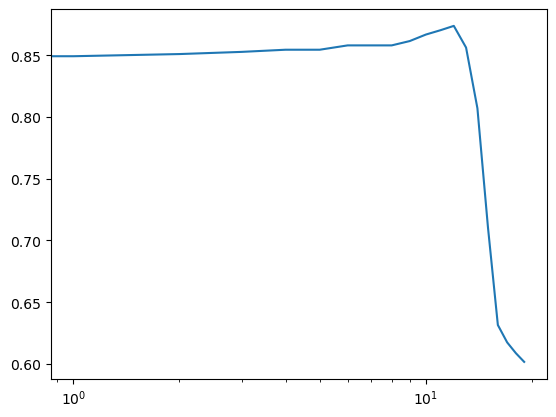

In [180]:
plt.figure()
plt.semilogx(acc)
plt.title("Accuracy depending of alpha ")
plt.xlabel("alpha (Laplace smoothing parameter")
plt.ylabel("accuracy")

## 8.3. Find the optimal $\alpha$ and its corresponding accuracy?  [Hint](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html)

In [184]:
bestind = np.argmax(acc)
best_acc = acc[bestind]
best_alpha = alphas[bestind]

In [185]:
grader.check("q8p3")

q8p3 results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [186]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False)